In [19]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import zscore
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import seaborn as sns


In [21]:
file_path = '/content/aug_train.csv'
data = pd.read_csv(file_path)

In [6]:
print("Missing values before imputation:\n", data.isnull().sum())

Missing values before imputation:
 enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64


In [7]:
for col in data.columns:
    if data[col].dtype == 'object':  # For categorical data, use mode
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:  # For numerical data, use mean
        data[col].fillna(data[col].mean(), inplace=True)

print("Missing values after imputation:\n", data.isnull().sum())

Missing values after imputation:
 enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64


<ipython-input-7-1c5c30480dda>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
<ipython-input-7-1c5c30480dda>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [8]:
# Identify numerical features
numerical_features = data.select_dtypes(include=[float, int]).columns

# Standardization (Z-score)- step 1
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

print("\nData after Standardization (Z-score):")
print(data[numerical_features].head())

# Min-Max Scaling- step 2
minmax_scaler = MinMaxScaler()
data[numerical_features] = minmax_scaler.fit_transform(data[numerical_features])

print("\nData after Min-Max Scaling:")
print(data[numerical_features].head())

# Save the processed dataset
scaled_file_path = "Scaled_Diabetes_with_Categorical.csv"
data.to_csv(scaled_file_path, index=False)
print(f"Scaled dataset saved to: {scaled_file_path}")


Data after Standardization (Z-score):
   enrollee_id  city_development_index  training_hours    target
0    -0.824285                0.738919       -0.488985  1.735070
1     1.336271               -0.428410       -0.305825 -0.576346
2    -0.552655               -1.660590        0.293607 -0.576346
3     1.701910               -0.323026       -0.222571  1.735070
4    -1.685658               -0.501368       -0.955209 -0.576346

Data after Min-Max Scaling:
   enrollee_id  city_development_index  training_hours  target
0     0.268073                0.942116        0.104478     1.0
1     0.890500                0.654691        0.137313     0.0
2     0.346326                0.351297        0.244776     0.0
3     0.995836                0.680639        0.152239     1.0
4     0.019923                0.636727        0.020896     0.0
Scaled dataset saved to: Scaled_Diabetes_with_Categorical.csv


In [13]:
# Define numerical columns for outlier detection
numerical_columns = ['enrollee_id', 'city_development_index', 'training_hours', 'target']

# Loop through numerical columns to detect and handle outliers
for col in numerical_columns:
    # Step 1: Detect outliers using Z-score
    data[f'{col}_zscore'] = (data[col] - data[col].mean()) / data[col].std()
    outliers = data[np.abs(data[f'{col}_zscore']) > 3]
    print(f"\nOutliers detected in {col}:\n", outliers)

    # Step 2: Handle outliers by capping
    data[f'{col}_capped'] = data[col]
    data.loc[np.abs(data[f'{col}_zscore']) > 3, f'{col}_capped'] = data[col].mean()

# Save the processed dataset
processed_file_path = "/content/aug_train.csv"
data.to_csv(processed_file_path, index=False)

print(f"\nProcessed dataset saved to: {processed_file_path}")


Outliers detected in enrollee_id:
 Empty DataFrame
Columns: [enrollee_id, city, city_development_index, gender, relevent_experience, enrolled_university, education_level, major_discipline, experience, company_size, company_type, last_new_job, training_hours, target, enrollee_id_zscore]
Index: []

Outliers detected in city_development_index:
        enrollee_id     city  city_development_index gender  \
1523      0.246772  city_33                     0.0   Male   
4744      0.928248  city_33                     0.0   Male   
5010      0.837922  city_33                     0.0   Male   
5265      0.934510  city_33                     0.0   Male   
5567      0.017885  city_33                     0.0   Male   
6127      0.556128  city_33                     0.0   Male   
7724      0.934060  city_33                     0.0   Male   
7864      0.804009  city_33                     0.0   Male   
9134      0.145511  city_33                     0.0   Male   
10401     0.583061  city_33        

In [28]:
# Ensure the target variable is binary
data['target'] = data['target'].round().astype(int)

# Define features (X) and target (y)
# Exclude categorical columns and the target variable
categorical_columns = [
    "enrollee_id", "city", "gender", "relevent_experience",
    "enrolled_university", "education_level", "major_discipline",
    "experience", "company_size", "company_type", "last_new_job"
]
X = data.drop(columns=categorical_columns + ["target"], errors="ignore")
y = data["target"]

# 1. Filter Method: Mutual Information
mi_selector = SelectKBest(score_func=mutual_info_classif, k="all")
mi_selector.fit(X, y)
mi_scores = pd.DataFrame({
    "Feature": X.columns,
    "Mutual_Info_Score": mi_selector.scores_
}).sort_values(by="Mutual_Info_Score", ascending=False)

# 2. Wrapper Method: Recursive Feature Elimination (RFE)
log_model = LogisticRegression(max_iter=1000, solver='liblinear')
rfe_selector = RFE(estimator=log_model, n_features_to_select=5)
rfe_selector.fit(X, y)
rfe_features = X.columns[rfe_selector.support_]

# 3. Embedded Method: Lasso Regression
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)
lasso_features = pd.DataFrame({
    "Feature": X.columns,
    "Lasso_Coefficient": lasso.coef_
}).sort_values(by="Lasso_Coefficient", ascending=False)
selected_lasso_features = lasso_features[lasso_features["Lasso_Coefficient"] != 0]

# Display Results
print("\nMutual Information Scores:")
print(mi_scores)

print("\nFeatures Selected by RFE:")
print(rfe_features.tolist())

print("\nLasso Regression Selected Features:")
print(selected_lasso_features)

# Save Results
mi_scores.to_csv("C:\\Users\\Dell\\Desktop\\Mutual_Information_Scores.csv", index=False)
selected_lasso_features.to_csv("C:\\Users\\Dell\\Desktop\\Lasso_Selected_Features.csv", index=False)



Mutual Information Scores:
                         Feature  Mutual_Info_Score
8                  target_zscore           0.563209
9                  target_capped           0.562113
4  city_development_index_zscore           0.073212
5  city_development_index_capped           0.068921
0         city_development_index           0.055078
3             enrollee_id_capped           0.015421
2             enrollee_id_zscore           0.014894
7          training_hours_capped           0.001532
1                 training_hours           0.000000
6          training_hours_zscore           0.000000

Features Selected by RFE:
['city_development_index', 'enrollee_id_capped', 'city_development_index_capped', 'target_zscore', 'target_capped']

Lasso Regression Selected Features:
         Feature  Lasso_Coefficient
8  target_zscore           0.422646


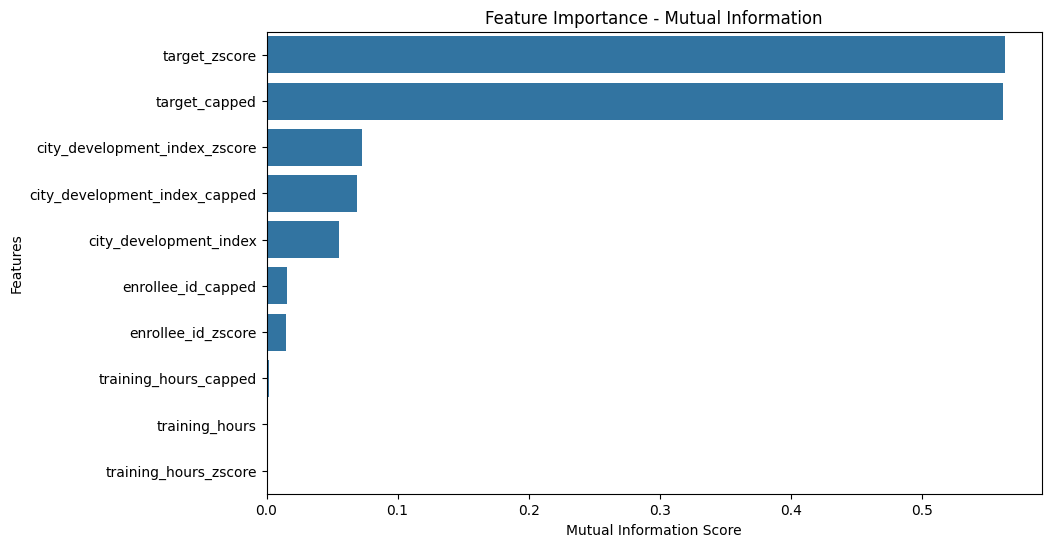

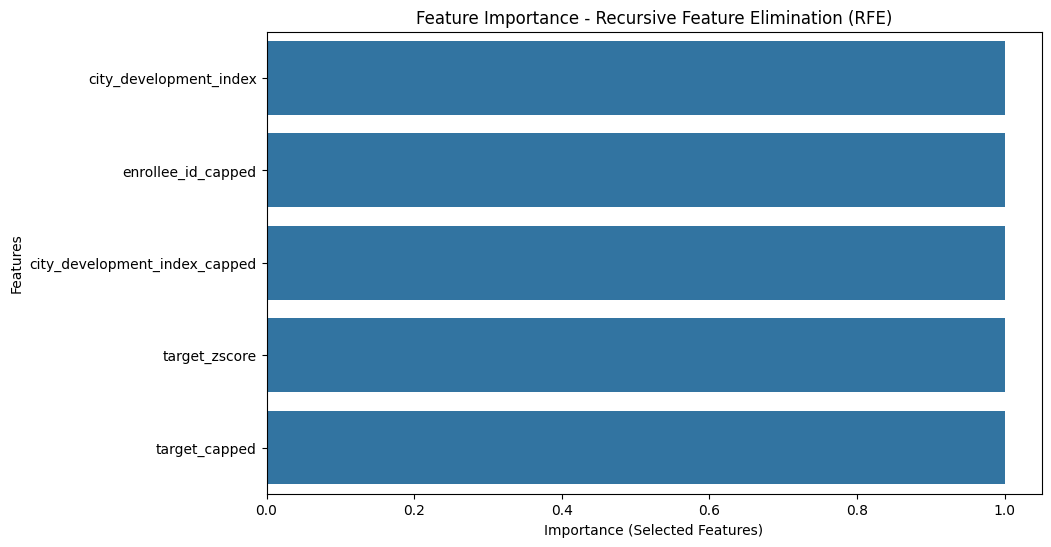

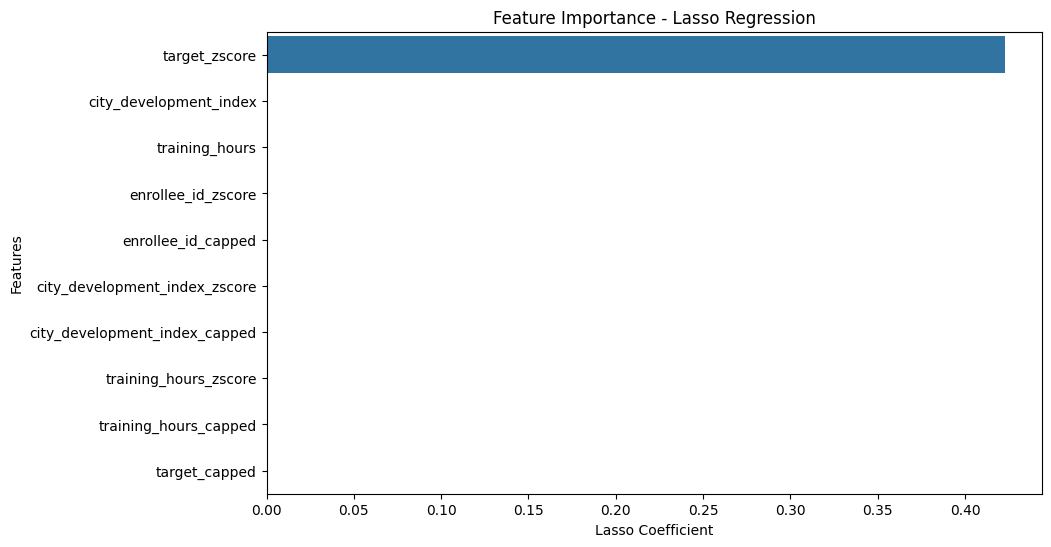

In [29]:
# 1. Plot Mutual Information Scores
plt.figure(figsize=(10, 6))
sns.barplot(x="Mutual_Info_Score", y="Feature", data=mi_scores)
plt.title("Feature Importance - Mutual Information")
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.show()

# 2. Plot RFE Selected Features
rfe_importance = pd.DataFrame({"Feature": rfe_features, "Importance": [1] * len(rfe_features)})  # Importance as a placeholder
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=rfe_importance)
plt.title("Feature Importance - Recursive Feature Elimination (RFE)")
plt.xlabel("Importance (Selected Features)")
plt.ylabel("Features")
plt.show()

# 3. Plot Lasso Regression Coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x="Lasso_Coefficient", y="Feature", data=lasso_features)
plt.title("Feature Importance - Lasso Regression")
plt.xlabel("Lasso Coefficient")
plt.ylabel("Features")
plt.show()